In [2]:

import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing as pp
sys.path.append(current_path+'/../calculate_tangent/')

import importlib
importlib.reload(pp)


<module 'post_processing' from '/home/lin.yang/projects/VECTOR/examples/plot_GG_property/../../post_processing.py'>

In [3]:

def get_normal_vector(grain_structure_figure_one, grain_num):
    nx = grain_structure_figure_one.shape[0]
    ny = grain_structure_figure_one.shape[1]
    ng = np.max(grain_structure_figure_one)
    cores = 8
    loop_times = 5
    P0 = grain_structure_figure_one
    R = np.zeros((nx,ny,2))
    smooth_class = linear2d.linear_class(nx,ny,ng,cores,loop_times,P0,R)

    smooth_class.linear_main("inclination")
    P = smooth_class.get_P()
    # sites = smooth_class.get_gb_list(1)
    # print(len(sites))
    # for id in range(2,grain_num+1): sites += smooth_class.get_gb_list(id)
    # print(len(sites))
    sites = smooth_class.get_all_gb_list()
    sites_together = []
    for id in range(len(sites)): sites_together += sites[id]
    print("Total num of GB sites: " + str(len(sites_together)))

    return P, sites_together
def get_normal_vector_slope(P, sites, step, para_name, bias=None):
    xLim = [0, 360]
    binValue = 10.01
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)

    freqArray = np.zeros(binNum)
    degree = []
    for sitei in sites:
        [i,j] = sitei
        dx,dy = myInput.get_grad(P,i,j)
        degree.append(math.atan2(-dy, dx) + math.pi)
        # if dx == 0:
        #     degree.append(math.pi/2)
        # elif dy >= 0:
        #     degree.append(abs(math.atan(-dy/dx)))
        # elif dy < 0:
        #     degree.append(abs(math.atan(dy/dx)))
    for i in range(len(degree)):
        freqArray[int((degree[i]/math.pi*180-xLim[0])/binValue)] += 1
    freqArray = freqArray/sum(freqArray*binValue)

    if bias is not None:
        freqArray = freqArray + bias
        freqArray = freqArray/sum(freqArray*binValue)
    # Plot
    # plt.close()
    # fig = plt.figure(figsize=(5, 5))
    # ax = plt.gca(projection='polar')

    # ax.set_thetagrids(np.arange(0.0, 360.0, 20.0),fontsize=14)
    # ax.set_thetamin(0.0)
    # ax.set_thetamax(360.0)

    # ax.set_rgrids(np.arange(0, 0.008, 0.004))
    # ax.set_rlabel_position(0.0)  # 标签显示在0°
    # ax.set_rlim(0.0, 0.008)  # 标签范围为[0, 5000)
    # ax.set_yticklabels(['0', '0.004'],fontsize=14)

    # ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)
    # ax.set_axisbelow('True')
    plt.plot(np.append(xCor,xCor[0])/180*math.pi, np.append(freqArray,freqArray[0]), linewidth=2, label=para_name)

    # fitting
    fit_coeff = np.polyfit(xCor, freqArray, 1)
    return freqArray


In [13]:

if __name__ == '__main__':
    # File name
    data_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/plot_GG_property_data"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/3d_poly_fully/results/"
    TJ_energy_type_array = np.array(["kt0.00","kt0.30","kt0.66","kt1.00","kt1.30","kt1.60","kt1.95","kt2.30","kt2.60"])
    label_list = [r"$kT=0.00$",r"$kT=0.30$",r"$kT=0.66$",r"$kT=1.00$",r"$kT=1.30$",r"$kT=1.60$",r"$kT=1.95$",r"$kT=2.30$",r"$kT=2.60$"]
    x_sticks_list = [0,0.3,0.66,1,1.3,1.6,1.95,2.3,2.6]
    # TJ_energy_type_array = np.array(["kt0.00","kt0.66","kt1.30","kt1.95","kt2.60"])
    # label_list = [r"$kT=0.00$",r"$kT=0.66$",r"$kT=1.30$",r"$kT=1.95$",r"$kT=2.60$"]
    # x_sticks_list = [0,0.66,1.3,1.95,2.66]
    
    initial_grain_num = 20000
    expected_grain_num = 1000
    grain_num_list = []
    special_step_distribution = np.zeros(len(TJ_energy_type_array),dtype=int)
    npy_step_slice = []

    for i in tqdm(range(len(TJ_energy_type_array))):
        npy_file_name = f"p_iso_450_20k_multiCore64_J1_refer_1_0_0_seed56689_{TJ_energy_type_array[i]}.npy"
        # Initial data
        npy_file = np.load(npy_file_folder + npy_file_name)
    
        grain_num_list.append(np.zeros(npy_file.shape[0]))
        # Calculate the number of grains
        for j in range(npy_file.shape[0]):
            unique_id_num = len(np.unique(npy_file[j,:]))
            grain_num_list[i][j] = unique_id_num
            if unique_id_num < expected_grain_num*0.9: break # jump out of the loop if the id is too less

    
        special_step_distribution[i] = int(np.argmin(abs(grain_num_list[i] - expected_grain_num)))
        npy_step_slice.append(npy_file[special_step_distribution[i],:])
    print("Found time steps")


    

100%|██████████| 9/9 [30:47<00:00, 205.32s/it]

Found time steps


In [6]:
#     for i in tqdm(range(5,9)):
#         npy_file_name = f"p_iso_450_20k_multiCore64_J1_refer_1_0_0_seed56689_{TJ_energy_type_array[i]}.npy"
#         # Initial data
#         npy_file = np.load(npy_file_folder + npy_file_name)
    
#         grain_num_list.append(np.zeros(npy_file.shape[0]))
#         # Calculate the number of grains
#         for j in range(npy_file.shape[0]):
#             unique_id_num = len(np.unique(npy_file[j,:]))
#             grain_num_list[i][j] = unique_id_num
#             if unique_id_num < expected_grain_num*0.9: break # jump out of the loop if the id is too less

    
#         special_step_distribution[i] = int(np.argmin(abs(grain_num_list[i] - expected_grain_num)))
#         npy_step_slice.append(npy_file[special_step_distribution[i],:])
#     print("Found time steps")

In [4]:
special_step_distribution

array([60, 44, 39, 44, 36])

In [ ]:
    # Start polar figure
    
    # XOY
    
    
    aniso_mag_XOY = np.zeros(len(TJ_energy_type_array))

    for i in tqdm(range(len(TJ_energy_type_array))):
        plt.figure()
        fig = plt.figure(figsize=(5, 5))
        ax = plt.gca(projection='polar')

        ax.set_thetagrids(np.arange(0.0, 360.0, 45.0),fontsize=14)
        ax.set_thetamin(0.0)
        ax.set_thetamax(360.0)

        ax.set_rgrids(np.arange(0, 0.005, 0.004))
        ax.set_rlabel_position(0.0) 
        ax.set_rlim(0.0, 0.005) 
        ax.set_yticklabels(['0', '0.004'],fontsize=14)

        ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)
        ax.set_axisbelow('True')
        data_file_name = f"/3D_normal_distribution_data/normal_distribution_iso_450D20k_{TJ_energy_type_array[i]}_G{expected_grain_num}.npz"
        if os.path.exists(data_folder + data_file_name):
            npz_file = np.load(data_folder + data_file_name)
            P = npz_file["P"]
            sites = npz_file["sites"]
        else:
            newplace = np.rot90(npy_step_slice[i][:,:,:], 1, (0,1))
            P, sites,_ = pp.get_normal_vector_3d(newplace,verification_system = False)
            np.savez(data_folder + data_file_name, P=P, sites=sites)

        slope_list = pp.get_normal_vector_slope_3d(P, sites, special_step_distribution[i], label_list[i])
        aniso_mag_XOY[i], _ = pp.simple_magnitude(slope_list)

        plt.text(0.0, 0.0060, "X", fontsize=20)
        plt.text(np.pi/2, 0.0060, "Y", fontsize=20)
        # plt.legend(loc=(-0.25,-0.3),fontsize=14,ncol=3)
        # plt.title(f"{label_list[i]}", fontsize=20)
        plt.savefig(current_path + f"/figures/normal_distribution_3DkT_XOY_case{i}.png", dpi=400,bbox_inches='tight')
    
    # XOZ
    
    
    aniso_mag_XOZ = np.zeros(len(TJ_energy_type_array))

    for i in tqdm(range(len(TJ_energy_type_array))):
        plt.figure()
        fig = plt.figure(figsize=(5, 5))
        ax = plt.gca(projection='polar')

        ax.set_thetagrids(np.arange(0.0, 360.0, 45.0),fontsize=14)
        ax.set_thetamin(0.0)
        ax.set_thetamax(360.0)

        ax.set_rgrids(np.arange(0, 0.005, 0.004))
        ax.set_rlabel_position(0.0) 
        ax.set_rlim(0.0, 0.005) 
        ax.set_yticklabels(['0', '0.004'],fontsize=14)

        ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)
        ax.set_axisbelow('True')
        data_file_name = f"/3D_normal_distribution_data/normal_distribution_iso_450D20k_{TJ_energy_type_array[i]}_G{expected_grain_num}.npz"
        if os.path.exists(data_folder + data_file_name):
            npz_file = np.load(data_folder + data_file_name)
            P = npz_file["P"]
            sites = npz_file["sites"]
        else:
            newplace = np.rot90(npy_step_slice[i][:,:,:], 1, (0,1))
            P, sites,_ = pp.get_normal_vector_3d(newplace,verification_system = False)
            np.savez(data_folder + data_file_name, P=P, sites=sites)

        slope_list = pp.get_normal_vector_slope_3d(P, sites, special_step_distribution[i], label_list[i],1)
        aniso_mag_XOZ[i], _ = pp.simple_magnitude(slope_list)


        plt.text(0.0, 0.0060, "X", fontsize=20)
        plt.text(np.pi/2, 0.0060, "Z", fontsize=20)
        # plt.legend(loc=(-0.25,-0.3),fontsize=14,ncol=3)
        # plt.title(f"{label_list[i]}", fontsize=20)
        plt.savefig(current_path + f"/figures/normal_distribution_3DkT_XOZ_case{i}.png", dpi=400,bbox_inches='tight')
    
    # YOZ
    
    
    aniso_mag_YOZ = np.zeros(len(TJ_energy_type_array))

    for i in tqdm(range(len(TJ_energy_type_array))):
        plt.figure()
        fig = plt.figure(figsize=(5, 5))
        ax = plt.gca(projection='polar')

        ax.set_thetagrids(np.arange(0.0, 360.0, 45.0),fontsize=14)
        ax.set_thetamin(0.0)
        ax.set_thetamax(360.0)

        ax.set_rgrids(np.arange(0, 0.005, 0.004))
        ax.set_rlabel_position(0.0) 
        ax.set_rlim(0.0, 0.005) 
        ax.set_yticklabels(['0', '0.004'],fontsize=14)

        ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)
        ax.set_axisbelow('True')
        data_file_name = f"/3D_normal_distribution_data/normal_distribution_iso_450D20k_{TJ_energy_type_array[i]}_G{expected_grain_num}.npz"
        if os.path.exists(data_folder + data_file_name):
            npz_file = np.load(data_folder + data_file_name)
            P = npz_file["P"]
            sites = npz_file["sites"]
        else:
            newplace = np.rot90(npy_step_slice[i][:,:,:], 1, (0,1))
            P, sites,_ = pp.get_normal_vector_3d(newplace,verification_system = False)
            np.savez(data_folder + data_file_name, P=P, sites=sites)

        slope_list = pp.get_normal_vector_slope_3d(P, sites, special_step_distribution[i], label_list[i],2)
        aniso_mag_YOZ[i], _ = pp.simple_magnitude(slope_list)


        plt.text(0.0, 0.0060, "Y", fontsize=20)
        plt.text(np.pi/2, 0.0060, "Z", fontsize=20)
        # plt.legend(loc=(-0.25,-0.3),fontsize=14,ncol=3)
        # plt.title(f"{label_list[i]}", fontsize=20)
        plt.savefig(current_path + f"/figures/normal_distribution_3DkT_YOZ_case{i}.png", dpi=400,bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

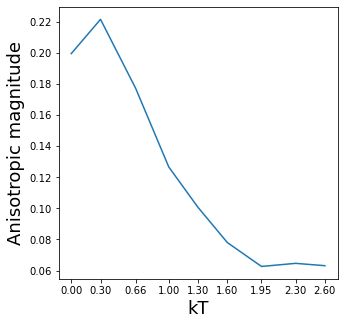

In [9]:
    # strength
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    
    aniso_mag = (aniso_mag_XOY + aniso_mag_XOZ + aniso_mag_YOZ)/3
    
    plt.plot(x_sticks_list, aniso_mag)
    plt.xlabel('kT',fontsize=18)
    plt.xticks(x_sticks_list)
    plt.ylabel('Anisotropic magnitude',fontsize=18)
    plt.savefig(current_path + "/figures/normal_distribution_3DkT_strength.png", dpi=400,bbox_inches='tight')

In [ ]:
# 1.3 is lowest at 500 expected grains

100%|██████████| 9/9 [06:01<00:00, 40.16s/it]


<Figure size 432x288 with 0 Axes>

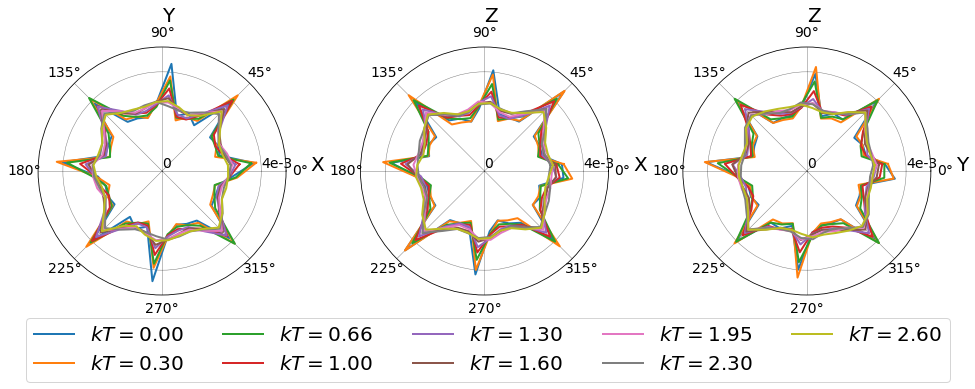

In [17]:
    # Start polar figure
    
    # XOY
    aniso_mag_XOY = np.zeros(len(TJ_energy_type_array))
    aniso_mag_XOZ = np.zeros(len(TJ_energy_type_array))
    aniso_mag_YOZ = np.zeros(len(TJ_energy_type_array))

    plt.figure()
    fig = plt.figure(figsize=(16, 5))
    
    ax = fig.add_subplot(131, projection='polar')
    ax.set_thetagrids(np.arange(0.0, 360.0, 45.0),fontsize=14)
    ax.set_thetamin(0.0)
    ax.set_thetamax(360.0)

    ax.set_rgrids(np.arange(0, 0.005, 0.004))
    ax.set_rlabel_position(0.0) 
    ax.set_rlim(0.0, 0.005) 
    ax.set_yticklabels(['0', '4e-3'],fontsize=14)

    ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)
    ax.set_axisbelow('True')
    for i in tqdm(range(len(TJ_energy_type_array))):
        data_file_name = f"/3D_normal_distribution_data/normal_distribution_iso_450D20k_{TJ_energy_type_array[i]}_G{expected_grain_num}.npz"
        if os.path.exists(data_folder + data_file_name):
            npz_file = np.load(data_folder + data_file_name)
            P = npz_file["P"]
            sites = npz_file["sites"]
        else:
            newplace = np.rot90(npy_step_slice[i][:,:,:], 1, (0,1))
            P, sites,_ = pp.get_normal_vector_3d(newplace,verification_system = False)
            np.savez(data_folder + data_file_name, P=P, sites=sites)

    
        slope_list = pp.get_normal_vector_slope_3d(P, sites, special_step_distribution[i], label_list[i])
        aniso_mag_XOY[i], _ = pp.simple_magnitude(slope_list)

    plt.text(0.0, 0.0060, "X", fontsize=20)
    plt.text(np.pi/2, 0.0060, "Y", fontsize=20)
    plt.subplots_adjust(wspace=0.3)
    plt.legend(loc=(-0.05,-0.35),fontsize=20,ncol=5)
    
    # XOZ
    ax = fig.add_subplot(132, projection='polar')
    ax.set_thetagrids(np.arange(0.0, 360.0, 45.0),fontsize=14)
    ax.set_thetamin(0.0)
    ax.set_thetamax(360.0)

    ax.set_rgrids(np.arange(0, 0.005, 0.004))
    ax.set_rlabel_position(0.0) 
    ax.set_rlim(0.0, 0.005) 
    ax.set_yticklabels(['0', '4e-3'],fontsize=14)

    ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)
    ax.set_axisbelow('True')
    for i in tqdm(range(len(TJ_energy_type_array))):
        data_file_name = f"/3D_normal_distribution_data/normal_distribution_iso_450D20k_{TJ_energy_type_array[i]}_G{expected_grain_num}.npz"
        if os.path.exists(data_folder + data_file_name):
            npz_file = np.load(data_folder + data_file_name)
            P = npz_file["P"]
            sites = npz_file["sites"]
        else:
            newplace = np.rot90(npy_step_slice[i][:,:,:], 1, (0,1))
            P, sites,_ = pp.get_normal_vector_3d(newplace,verification_system = False)
            np.savez(data_folder + data_file_name, P=P, sites=sites)

        slope_list = pp.get_normal_vector_slope_3d(P, sites, special_step_distribution[i], label_list[i],1)
        aniso_mag_XOZ[i], _ = pp.simple_magnitude(slope_list)

    plt.text(0.0, 0.0060, "X", fontsize=20)
    plt.text(np.pi/2, 0.0060, "Z", fontsize=20)
    plt.subplots_adjust(wspace=0.3)
    
    # YOZ
    ax = fig.add_subplot(133, projection='polar')

    ax.set_thetagrids(np.arange(0.0, 360.0, 45.0),fontsize=14)
    ax.set_thetamin(0.0)
    ax.set_thetamax(360.0)

    ax.set_rgrids(np.arange(0, 0.005, 0.004))
    ax.set_rlabel_position(0.0) 
    ax.set_rlim(0.0, 0.005) 
    ax.set_yticklabels(['0', '4e-3'],fontsize=14)

    ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)
    ax.set_axisbelow('True')
    for i in tqdm(range(len(TJ_energy_type_array))):
        data_file_name = f"/3D_normal_distribution_data/normal_distribution_iso_450D20k_{TJ_energy_type_array[i]}_G{expected_grain_num}.npz"
        if os.path.exists(data_folder + data_file_name):
            npz_file = np.load(data_folder + data_file_name)
            P = npz_file["P"]
            sites = npz_file["sites"]
        else:
            newplace = np.rot90(npy_step_slice[i][:,:,:], 1, (0,1))
            P, sites,_ = pp.get_normal_vector_3d(newplace,verification_system = False)
            np.savez(data_folder + data_file_name, P=P, sites=sites)

        slope_list = pp.get_normal_vector_slope_3d(P, sites, special_step_distribution[i], label_list[i],2)
        aniso_mag_YOZ[i], _ = pp.simple_magnitude(slope_list)


    plt.text(0.0, 0.0060, "Y", fontsize=20)
    plt.text(np.pi/2, 0.0060, "Z", fontsize=20)
    plt.subplots_adjust(wspace=0.3)
    # plt.legend(loc=(-0.25,-0.3),fontsize=14,ncol=9)
    plt.savefig(current_path + f"/figures/normal_distribution_3DkT_three.png", dpi=400,bbox_inches='tight')

